<a href="https://colab.research.google.com/github/DepartmentOfStatisticsPUE/bi-2022/blob/main/notebooks/2-quasi-cal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pobieramy dane z github wykorzystując funkcję `download.file`


In [1]:
download.file("https://raw.githubusercontent.com/DepartmentOfStatisticsPUE/bi-2021/main/data/popyt-zajecia-dane.csv",
              "popyt-dane.csv")

Instalujemy pakiet `survey`.

In [2]:
install.packages("survey")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘minqa’, ‘numDeriv’, ‘mitools’




Ładujemy potrzebne pakiety

In [ ]:
library(tidyverse) ## przetwarzanie
library(survey) ## funkcja calibrate

Opis funkcji `calibrate` z pakietu `survey`.

```
calibrate(design, formula, population,
       aggregate.stage=NULL, stage=0, variance=NULL,
       bounds=c(-Inf,Inf), calfun=c("linear","raking","logit"),
       maxit=50,epsilon=1e-7,verbose=FALSE,force=FALSE,trim=NULL,
       bounds.const=FALSE, sparse=FALSE,...)
```

Opis wybranych argumentów:

+ `design` -- obiekt typu `survey.design`, który tworzymy funkcją `svydesign`,
+ `formula` -- określamy zmienne wykorzystywane do kalibracji w postaci formuły (np. `~ x1 + x2`, `list(~x1, ~x2)`),
+ `population` -- dane z populacji (wektor albo lista z wartościami),
+ `bounds` -- zakres zmienności wag,
+ `calfun` -- funkcja kalibracyjna,
+ `trim` -- czy chcemy uciąć ekstremalne wagi.

Wczytujemy dane do R

In [4]:
dane <- read.csv("popyt-dane.csv", stringsAsFactors = FALSE)
head(dane)

,id_popyt,id_jednostki,waga,sek,klasa_pr,sekc_pkd,woj,zawod_kod2,wolne_miejsca,id_cbop,jedna_zmiana,wymiar_40,wolne_miejsca_cbop,wolne_miejsca_niepeln_cbop
,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>,<lgl>,<int>,<int>
1,1,a9cc990df6a99ab215a1bc13f51d4825c7d52d18,1,1,D,O,14,1,2,NA,NA,NA,NA,NA
2,2,a9cc990df6a99ab215a1bc13f51d4825c7d52d18,1,1,D,O,14,2,7,NA,NA,NA,NA,NA
3,3,c9dbaf50890165ebe810aa770de0e9df903dc35b,6,1,D,O,24,2,6,NA,NA,NA,NA,NA
4,4,718e0bba42bcec6ed98f9690db6d26cb7b93c880,1,1,D,R.S,14,2,7,NA,NA,NA,NA,NA
5,5,532a1879a692b9d7bbb7282ba757d028156ef341,1,1,D,R.S,14,2,6,NA,NA,NA,NA,NA
6,6,0b6b623fa45e257284a3049d097af322841337e3,1,1,D,R.S,22,2,1,NA,NA,NA,NA,NA


W pierwszej kolejnosci utworzymy sobie dwa zbiory danych, które będą zawierały: 

+ próbę losową
+ próbę nielosową

In [5]:
proba_losowa <- dane %>% 
    filter(!is.na(id_popyt)) %>%  #
    select(id_popyt:wolne_miejsca) %>%
    mutate(sek = as.character(sek),
           klasa_pr = as.character(klasa_pr),
           zawod_kod2 = as.character(zawod_kod2))

proba_nielos <- dane %>% 
    filter(!is.na(id_cbop)) %>% 
    select(id_cbop:wolne_miejsca_niepeln_cbop, sek:zawod_kod2) %>%
    mutate(sek = as.character(sek),
           klasa_pr = as.character(klasa_pr),
           zawod_kod2 = as.character(zawod_kod2))

head(proba_nielos)

,id_cbop,jedna_zmiana,wymiar_40,wolne_miejsca_cbop,wolne_miejsca_niepeln_cbop,sek,klasa_pr,sekc_pkd,woj,zawod_kod2
,<int>,<lgl>,<lgl>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>
1,1,FALSE,TRUE,1,0,1,D,P,30,3
2,1,TRUE,TRUE,1,0,1,D,O,14,3
3,1,TRUE,TRUE,1,0,1,D,O,14,4
4,1,TRUE,TRUE,1,0,1,D,O,4,4
5,1,TRUE,TRUE,4,0,1,D,O,24,4
6,1,TRUE,TRUE,1,0,1,D,O,4,3


Załóżmy, że chcemy odtworzyć wartości globalne (tj. liczbę wolnych miejsc pracy) według następujących zmiennych:

+ `sek` -- sektor własności
+ `klasa_pr` -- klasa wielkości
+ `zawod_kod2` -- kod zawodu

In [6]:
proba_losowa %>%
  group_by(zawod_kod2) %>%
  summarise(wynik = sum(wolne_miejsca*waga))

zawod_kod2,wynik
<chr>,<int>
1,11298
2,39141
3,19823
4,27414
5,51709
7,73566
8,47146
9,24197


W przypadku pakietu survey najlepszym sposobem jest utworzenie wartości globalnych z wykorzystaniem funkcji `xtabs`. Proszę pamietać, że zmienne w obydwu zbiorach danych muszą nazywać się tak samo oraz muszą mieć takie same poziomy.

In [7]:
total_sek <- xtabs(wolne_miejsca*waga ~ sek, data = proba_losowa)
total_wielk <- xtabs(wolne_miejsca*waga ~ klasa_pr, data = proba_losowa)
total_zawod <- xtabs(wolne_miejsca*waga ~ zawod_kod2, data = proba_losowa)
total_zawod

zawod_kod2
    1     2     3     4     5     7     8     9 
11298 39141 19823 27414 51709 73566 47146 24197 

Tworzymy obiekt `survey.design` na podstawie próby nielosowej. Zmienna `wolne_miejsca_cbop` zostanie wykorzystana jako wejściowa waga (pseudo-waga) ponieważ ona określa ile razy dany wiersz powinien zostać powtórzony.

In [8]:
svy_nielos <- svydesign(ids = ~1, weight = ~ wolne_miejsca_cbop, data = proba_nielos)
svy_nielos

Independent Sampling design (with replacement)
svydesign(ids = ~1, weight = ~wolne_miejsca_cbop, data = proba_nielos)

In [9]:
svytable(~zawod_kod2, svy_nielos)

zawod_kod2
   1    2    3    4    5    7    8    9 
 297 1871 1660 2931 4756 6734 4109 6086 

Przechodzimy do kalibracji z wykorzystaniem funkcji `calibrate`. Wykonamy dwie kalibracje według dwóch różnych zestawów wag:

1. Zapis `list(~ sek, ~zawod_kod2)` oznacza, że kalibrujemy niezależnie dla sekcji (`sek`) oraz zawodów (`zawod_kod2`).
2. Zapis `list(~ sek, ~zawod_kod2, ~klasa_pr)` oznacza, że kalibrujemy niezależnie dla sekcji (`sek`), zawodów (`zawod_kod2`) oraz wielkości podmiotu (`klasa_pr`).

In [10]:
## pierwszy zestaw
svy_nielos_calib <- calibrate(
  design = svy_nielos,
  formula = list(~sek, ~zawod_kod2), 
  population = list(total_sek, total_zawod)
)

## drugi zestaw
svy_nielos_calib2 <- calibrate(
  design = svy_nielos,
  formula = list(~sek, ~zawod_kod2, ~klasa_pr), 
  population = list(total_sek, total_zawod, total_wielk)
)

Oszacujmy jaki był odsetek podmiotów, które ofertowały pracę na jedną zmianę.

+ Bez uwzględnienia kalibracji ten odsetek wynosił 51%
+ Po uwzględnieniu kalibracji ten odsetek wynosił 53% (sek, zawod)
+ Po uwzględnieniu kalibracji ten odsetek wynosił 62% (sek, zawod, wielkość)

In [11]:
svymean(~jedna_zmiana, svy_nielos)
svymean(~jedna_zmiana, svy_nielos_calib)
svymean(~jedna_zmiana, svy_nielos_calib2)

                    mean     SE
jedna_zmianaFALSE 0.4943 0.0128
jedna_zmianaTRUE  0.5057 0.0128

                     mean     SE
jedna_zmianaFALSE 0.46708 0.0112
jedna_zmianaTRUE  0.53292 0.0112

                     mean     SE
jedna_zmianaFALSE 0.38032 0.0074
jedna_zmianaTRUE  0.61968 0.0074

## Kalibracja na różnych poziomach

Poniżej przedstawiam przykład, w którym kalibracji dokonuje się na dwóch różnych poziomach co nie jest możliwe w przypadku post-stratyfikacji. Celem będzie odtworzenie liczby podmiotów według ich wielkości (1 poziom) oraz liczby wakatów według wielkości podmiotów (2 poziom). Czyli będę chciał utworzyć takie wagi aby po ich zsumowaniu uzyskać zgodność zarówno w zakresie wielkości populacji referencyjnej (czyli liczby podmiotów w Polsce), jak i estymowanej liczby wolnych miejsc pracy w tych podmiotach. 

Zadanie to wykonane będzie w dwóch krokach:

1. Należy dodać zestaw zmiennych określających liczbę wakatów według wielkości podmiotu do zbioru `proba_nielos`. Utworzona zostanie również nowa waga odzwierciedlająca liczbę podmiotów, a nie liczbę wakatów.
2. Należy utworzyć specjalny wektor, który będzie zawierał wartości globalne z dwóch poziomów.


In [12]:
proba_nielos <- proba_nielos %>% 
    mutate(wakaty_d = ifelse(klasa_pr == "D", wolne_miejsca_cbop, 0),
           wakaty_m = ifelse(klasa_pr == "M", wolne_miejsca_cbop, 0),
           wakaty_s = ifelse(klasa_pr == "S", wolne_miejsca_cbop, 0),
           waga = sum(proba_losowa$waga)/n())

head(proba_nielos)

,id_cbop,jedna_zmiana,wymiar_40,wolne_miejsca_cbop,wolne_miejsca_niepeln_cbop,sek,klasa_pr,sekc_pkd,woj,zawod_kod2,wakaty_d,wakaty_m,wakaty_s,waga
,<int>,<lgl>,<lgl>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,FALSE,TRUE,1,0,1,D,P,30,3,1,0,0,5.368999
2,1,TRUE,TRUE,1,0,1,D,O,14,3,1,0,0,5.368999
3,1,TRUE,TRUE,1,0,1,D,O,14,4,1,0,0,5.368999
4,1,TRUE,TRUE,1,0,1,D,O,4,4,1,0,0,5.368999
5,1,TRUE,TRUE,4,0,1,D,O,24,4,4,0,0,5.368999
6,1,TRUE,TRUE,1,0,1,D,O,4,3,1,0,0,5.368999


Wartości globalne

In [16]:
total_klasa_pod <- xtabs(waga ~ klasa_pr, proba_losowa)
total_klasa_wak <- xtabs(waga*wolne_miejsca ~ klasa_pr, proba_losowa)

cat("===================")
print("Liczba podmiotów:")
total_klasa_pod
cat("===================")
print("Estymowana liczba wakatów:")
total_klasa_wak

===================[1] "Liczba podmiotów:"


klasa_pr
    D     M     S 
13099 32417 16104 

===================[1] "Estymowana liczba wakatów:"


klasa_pr
     D      M      S 
 94124 128940  71230 

In [17]:
proba_nielos_svy <- svydesign(ids= ~1, weights = ~waga, data = proba_nielos)
svytotal(~wakaty_s, proba_nielos_svy)

         total     SE
wakaty_s 37003 920.31

In [18]:
proba_nielos_svy_cal <- calibrate(design = proba_nielos_svy, 
                                  formula = ~klasa_pr+wakaty_d+wakaty_m+wakaty_s,
                                  population = c(
                                    "(Intercept)" = sum(total_klasa_pod),  ## liczba podmiotów ogółem
                                    "klasa_prM" = unname(total_klasa_pod[2]), ## liczba podmiotów małych
                                    "klasa_prS" = unname(total_klasa_pod[3]), ## liczba podmiotów srednich 
                                    "wakaty_d" = unname(total_klasa_wak[1]), ## liczba wakatów w duzych podmiotach
                                    "wakaty_m" = unname(total_klasa_wak[2]), ## liczba wakatow w małych podmiotach
                                    "wakaty_s" = unname(total_klasa_wak[3])) ## liczba wakatow w średnich podmiotach
                                    ) 

In [21]:
res = svyby(~wolne_miejsca_cbop, ~jedna_zmiana, proba_nielos_svy_cal, svytotal)
res

,jedna_zmiana,wolne_miejsca_cbop,se
,<lgl>,<dbl>,<dbl>
FALSE,FALSE,119136,6054.308
TRUE,TRUE,175158,6054.308


Estymator odsetka wolnych miejsc na jedną zmianę

In [22]:
weighted.mean(res$jedna_zmiana,res$wolne_miejsca_cbop)

[1] 0.5951803

## Mała symulacja 

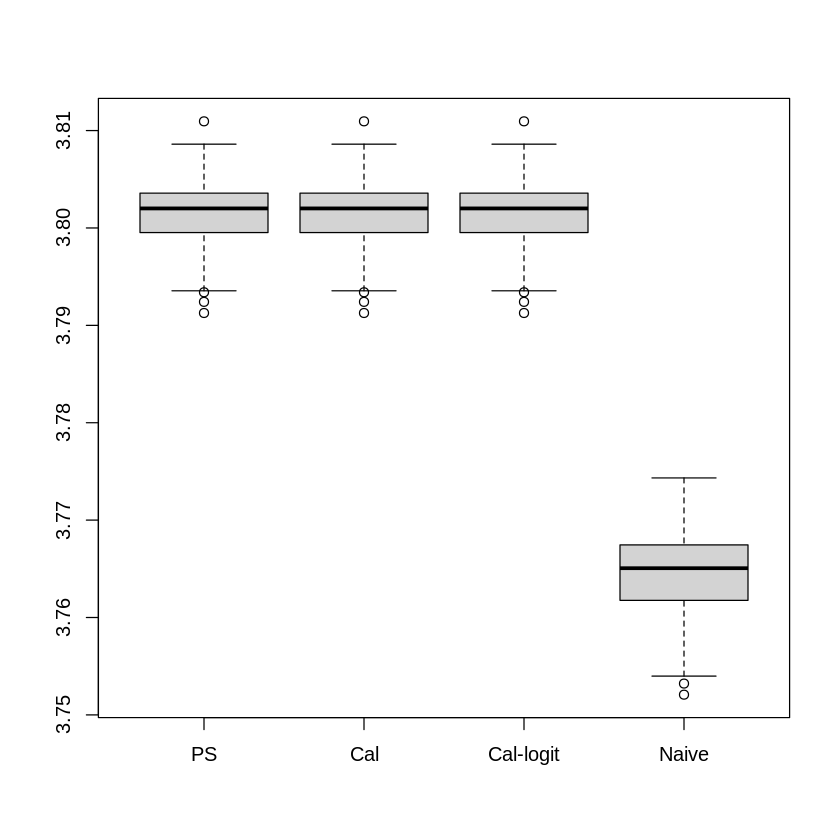

In [23]:
set.seed(123)
N <- 100000 ## wielkość populacji 
x <- sample(x = c("a", "b", "c", "d"), size = N, prob = c(0.2, 0.5, 0.1, 0.2), replace = T) 
y <- 4 - 0.3*(x=="b") + 2.5*(x == "c") - 1.5*(x == "d") + rnorm(N) ## zmienna celu
prob <- exp(-1 + 1.5*(x == "b")) / (1 + exp(-1 + 1.5*(x == "b")))
df <- data.frame(x=as.factor(x) , y, prob)
lm1 <- lm(y ~ x, data = df)
#summary(lm1)
B <- 100
wynik <- matrix(0, ncol = 4, nrow = B)
for (b in 1:B) {
  nonprob <- rbinom(n = N, size = 1, prob = prob)
  df_nonprob <- df[nonprob == 1, ]
  df_nonprob$waga <- N/nrow(df_nonprob)
  df_nonprob_svy <- svydesign(ids = ~1, strata = ~x, weights = ~ waga, data = df_nonprob)
  pop_totals <- xtabs(~x, data = df)
  ## post-stratyfikacja
  df_nonprob_svy_post <- postStratify(df_nonprob_svy, ~x, pop_totals)
  ## kalibracja
  df_nonprob_svy_cal <- calibrate(df_nonprob_svy, list(~x), list(pop_totals))
  ## kalibracja z funkcją logit
  df_nonprob_svy_cal_logit <- calibrate(df_nonprob_svy, list(~x), list(pop_totals), 
                                calfun = "logit", 
                                bounds = c(0.6, 1.8))
  wynik[b, 1] <- svymean(~y,df_nonprob_svy_post)[1]
  wynik[b, 2] <- svymean(~y,df_nonprob_svy_cal)[1]
  wynik[b, 3] <- svymean(~y,df_nonprob_svy_cal_logit)[1]
  wynik[b, 4] <- svymean(~y,df_nonprob_svy)[1]
}

colnames(wynik) <- c("PS","Cal", "Cal-logit", "Naive")
boxplot(wynik)